<a href="https://colab.research.google.com/github/srt3000/U_Net/blob/main/UNET_multiclass_segmentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
# Set some parameters
im_width = 512
im_height = 512
border = 5

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
images = "/content/drive/MyDrive/data/train_images"
ids = next(os.walk(images))[2] # list of names all images in the given path
print("No. of images = ", len(ids))


No. of images =  30


In [ ]:
#ids = next(os.walk("images"))[2] # list of names all images in the given path
#print("No. of images = ", len(ids))

No. of images =  4000


In [5]:
#Resize all the images to the width and height specified and save it in the destination folder
from PIL import Image
import os, sys

width = 512
height = 512
dim = (width, height)
train_im = '/content/drive/MyDrive/data/train_images/'
resized_train_im = '/content/drive/MyDrive/data/resized_train_images/'
train_masks = '/content/drive/MyDrive/data/train_masks/'
resized_train_masks='/content/drive/MyDrive/data/resized_train_masks/'
def resize_images(path,dest):

  dirs = os.listdir( path )
# create new folder if the destination folder is not present
  if not os.path.exists(dest):
      os.makedirs(dest)

  for item in dirs:
    if os.path.isfile(path+item):
      im = Image.open(path+item)
      f, e = os.path.splitext(path+item)
    # resize image
      imResize = im.resize((width,height), Image.ANTIALIAS)
    # save image to destination folder
      imResize.save('{}{}{}'.format(dest,'/',os.path.split(item)[1]))

resize_images(train_im,resized_train_im)
resize_images(train_masks,resized_train_masks)







In [7]:
X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)

#### Load the images and masks into arrays

In [8]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(resized_train_im+"/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (512, 512, 3), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img(resized_train_masks+"/"+id_, grayscale=True))
    mask = resize(mask, (512, 512, 3), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [9]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

TypeError: ignored

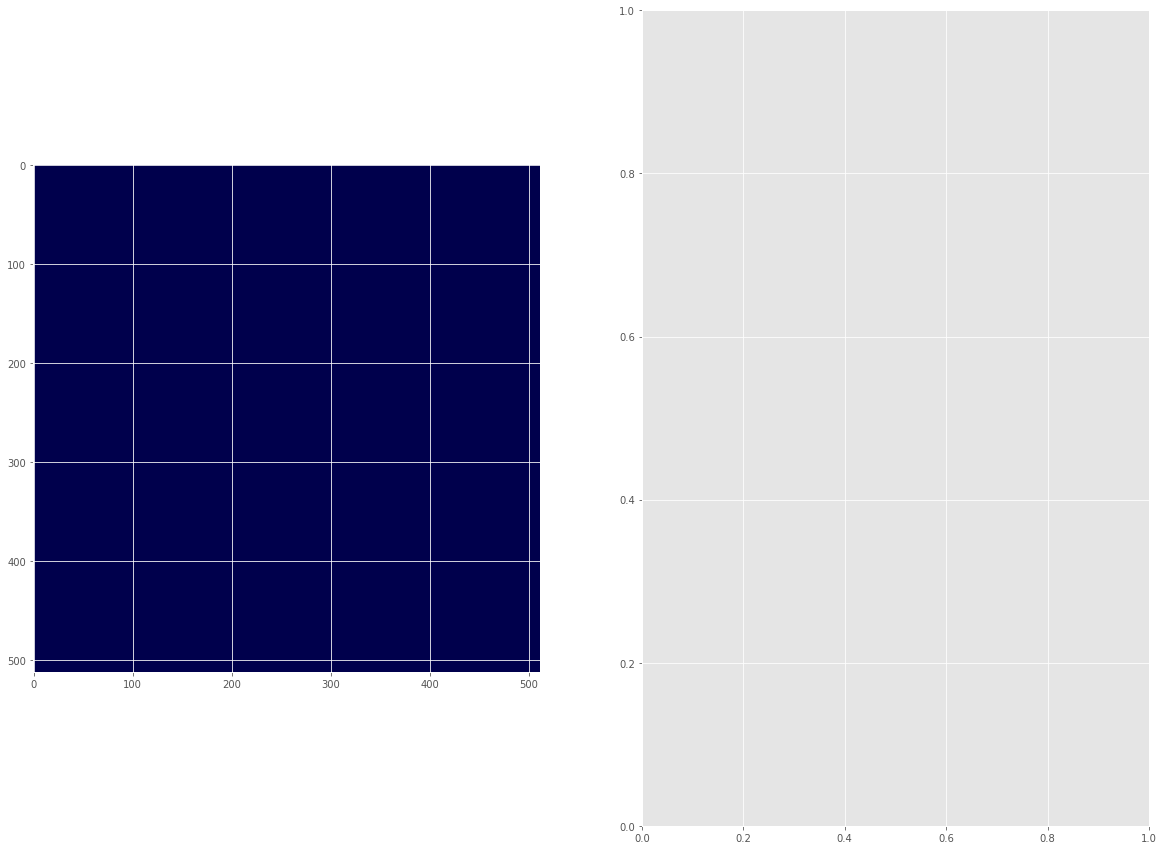

In [10]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Strawberry')

In [11]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [59]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='softmax')(c9)     ##Conv2D(4, (1, 1), here 4 means 4 classes
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [72]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-multclass-strawberry.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train, batch_size=4, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 512, 512, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_199 (BatchN (None, 512, 512, 16) 64          conv2d_210[0][0]                 
__________________________________________________________________________________________________
activation_199 (Activation)     (None, 512, 512, 16) 0           batch_normalization_199[0][0]    
___________________________________________________________________________________________

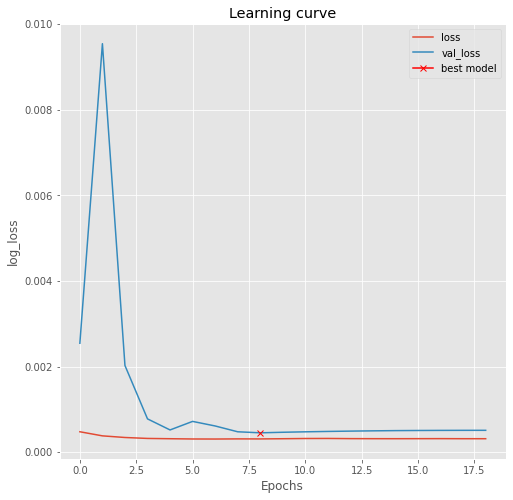

In [61]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [63]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.summary()
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-multiiclass-strawberry.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train, batch_size=4, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 512, 512, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, 512, 512, 16) 64          conv2d_172[0][0]                 
__________________________________________________________________________________________________
activation_163 (Activation)     (None, 512, 512, 16) 0           batch_normalization_163[0][0]    
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


InvalidArgumentError: ignored

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [62]:
!zip -r model.zip {export_path_sm}
!ls
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

	zip warning: name not matched: {export_path_sm}

zip error: Nothing to do! (try: zip -r model.zip . -i {export_path_sm})
drive  model-multclass-strawberry.h5  sample_data


FileNotFoundError: ignored

In [64]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.summary()
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-multiiclass-strawberry.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train, batch_size=4, epochs=300, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_191 (Conv2D)             (None, 512, 512, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_181 (BatchN (None, 512, 512, 16) 64          conv2d_191[0][0]                 
__________________________________________________________________________________________________
activation_181 (Activation)     (None, 512, 512, 16) 0           batch_normalization_181[0][0]    
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


InvalidArgumentError: ignored

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [73]:
# load the best model
model.load_weights('model-multclass-strawberry.h5')

In [74]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 4s 4s/step - loss: 4.5056e-04 - accuracy: 0.2706


[0.00045056254020892084, 0.2705802917480469]

In [75]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1/1 [==============================] - 1s 1s/step


In [76]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [77]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Strawberry')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Strawberry Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Strawberry Predicted binary');

### Predictions on training set

TypeError: ignored

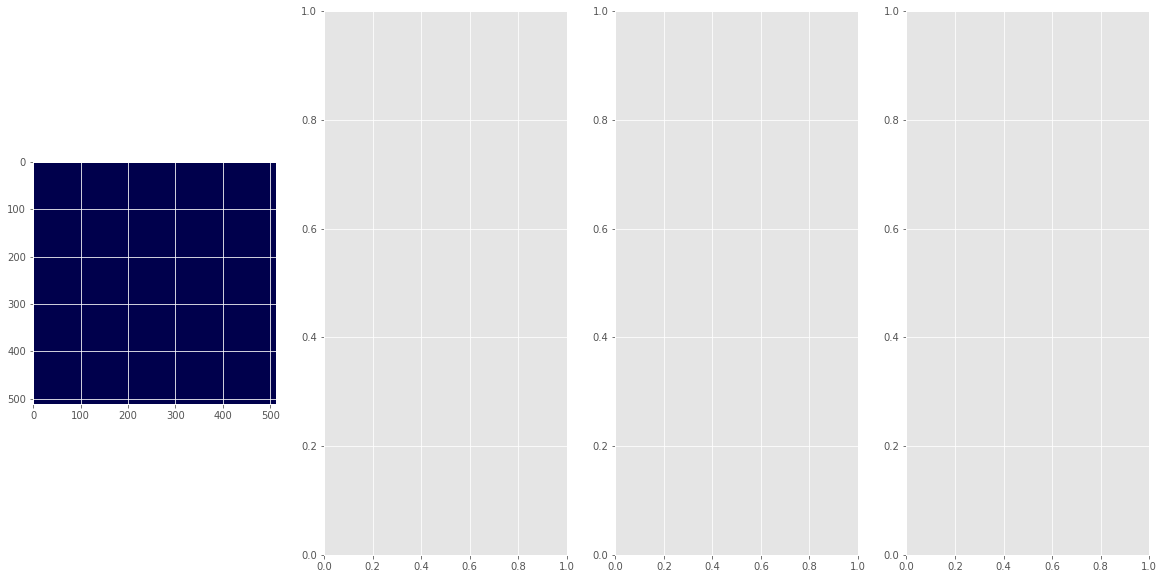

In [78]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [67]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

NameError: ignored

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [68]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

NameError: ignored

### Predictions on test set

In [69]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

NameError: ignored

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [47]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

NameError: ignored

In [48]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

NameError: ignored

In [49]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

NameError: ignored

In [50]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

NameError: ignored

In [51]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

NameError: ignored

In [52]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

NameError: ignored

In [53]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

NameError: ignored

In [54]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

NameError: ignored

In [55]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

NameError: ignored

In [56]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

NameError: ignored